In [1]:
from IPython.display import display, HTML

display(HTML('''
<script>
// Version optimisée pour JupyterLab 4.x
(function() {
    const style = document.createElement('style');
    style.textContent = `
        .jupyterlab-code-toggle {
            background: #e0e0e0;
            border: none;
            border-radius: 3px;
            padding: 3px 10px;
            margin: 5px 0;
            cursor: pointer;
        }
        .jupyterlab-code-toggle:hover {
            background: #d0d0d0;
        }
    `;
    document.head.appendChild(style);

    function toggleCode(cell) {
        const inputArea = cell.querySelector('.jp-Cell-inputArea');
        if (inputArea.style.display === 'none') {
            inputArea.style.display = 'flex';
        } else {
            inputArea.style.display = 'none';
        }
    }

    function addButtons() {
        document.querySelectorAll('.jp-CodeCell').forEach(cell => {
            if (!cell.querySelector('.jupyterlab-code-toggle')) {
                const btn = document.createElement('button');
                btn.className = 'jupyterlab-code-toggle';
                btn.textContent = '▸ Code';
                btn.onclick = () => toggleCode(cell);
                cell.insertBefore(btn, cell.firstChild);
            }
        });
    }

    // Surveillance en temps réel avec MutationObserver
    new MutationObserver(addButtons).observe(document.body, {
        childList: true,
        subtree: true
    });
})();
</script>
'''))

# Introduction

Dans ce projet nous allons détecter les déchets plastiques sur les côtes de Jamestown à Accra au Ghana avec les images Sentinel-2. 
les Images S-2 utilisées dans ce projet ont été corrigé en réflectance de surface avec le mdoèle de correction atmosphériques ACOLITE. En plus des bandes S-2 nous avons des indices Spectraux ainsi que des bandes obtenues par demixgae spectral (spectral unmixing) avec les réflectances de référence de nos classes d'intérêt. En gros une vingtaine de variable ont été utilisées dans ce projet pour entrainer un modèle Random Forest qui sont : **cotier, blue, green, red,  redE1, redE2, redE3, NIR,  NIR_A, MIR_1, MIR_2, NDVI (Normalize Difference Vegetation Index), KNDVI  ( Kernel Normalize Difference Vegetation Index), PI (Plastic Index), NIR_prime, FDI (Floating Debris Index), plastics_bottles_abundance, fish_net_abundance, blue_bags_abundance, water_abundance, HDPE_abundance, wooden_abundance**.


# Libraries à installer si nécéssaire

In [40]:
library(ggplot2)
library(tidyr)
library(lattice)
library(caret)
library(raster)
library(rasterVis)
library(randomForest)
library(iml)
library(xgboost)
library(kernelshap)
library(shapviz)
library(ranger)
library(MLmetrics)
library(pROC)
library(dplyr)
library(data.table)
library(shapr)
library(jpeg)

In [41]:
## augmenter les sorties des images 
options(jupyter.plot_scale = 1.5)   
options(repr.plot.width = 10)
options(repr.plot.height = 10)

# Construction de la base de données qui va servir pour entrainement et la validation du modèle

Dans ce projet nous avons collecté les données d'entrainement et de validation de nos classes d'intérêt à travers 5 sites différents dont nous connaissons la localisation des déchets plastiques. Des polygones ont été digitalisé sur la localisation de nos classes d'intérêts dans ces cinq sites pour extraire les valeurs de  nos variables d'intérêts afin de construire notre base de données.

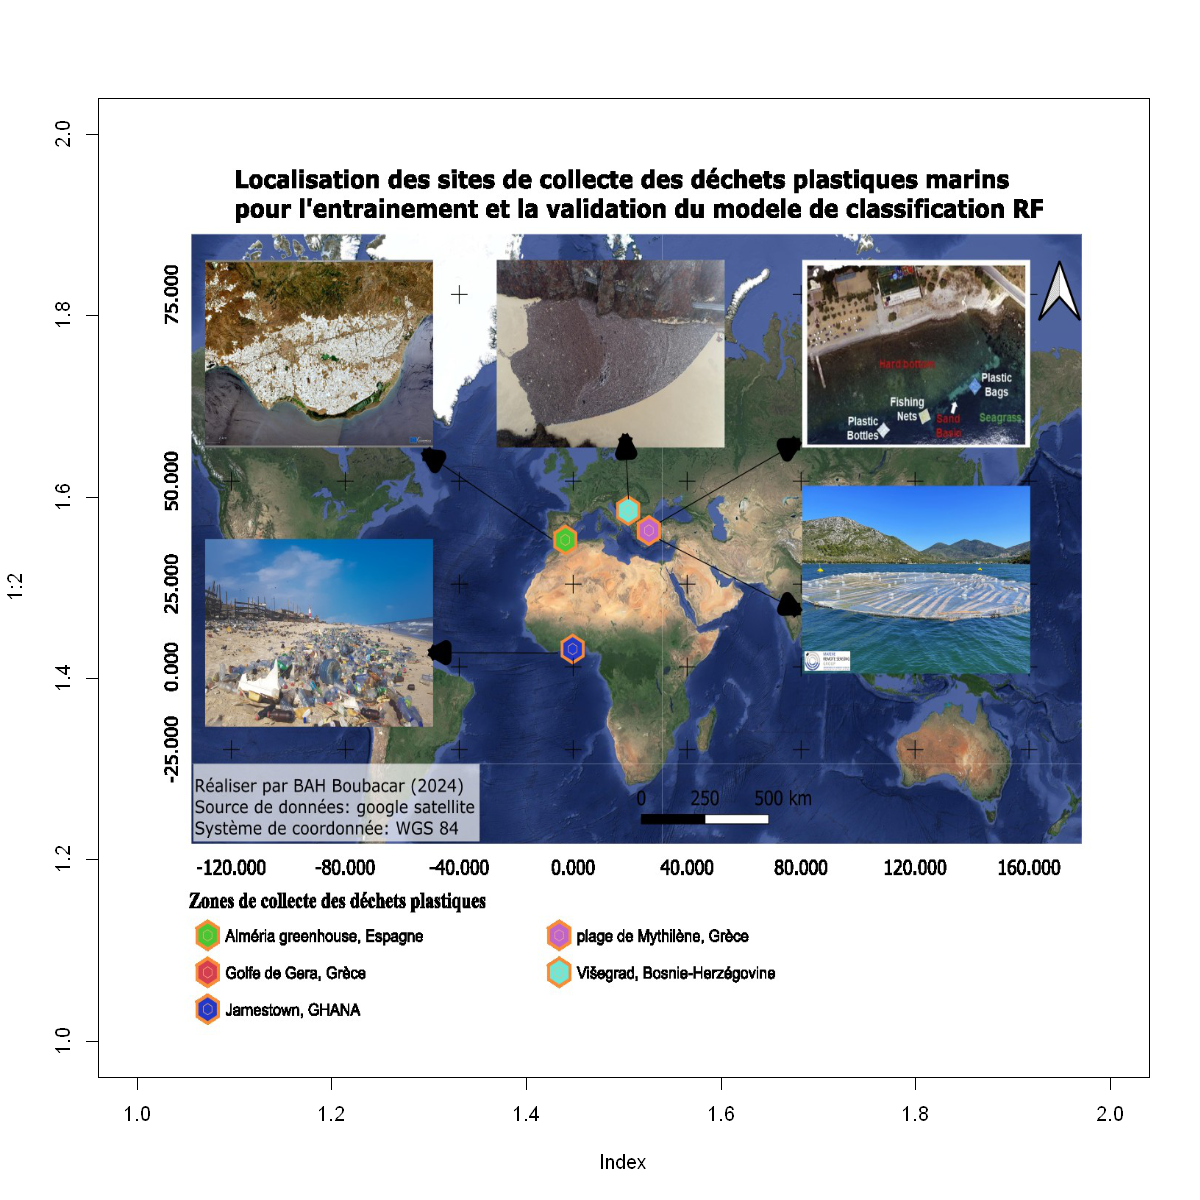

In [32]:
#Afficher le Map des sites d'entrainement
# -------------------------------
# absolute path to your NBKT folder
dir_base <- "C:/Users/HP/Desktop/bah/PARIS_CITE/M2_Paris_Cite/STAGE_M2/NBKT"
chemin_entre <- "./DATA_Coastal_Plastic"

setwd(dir_base)
setwd(chemin_entre)

img <- readJPEG("./training_zone_map.jpg")
plot(1:2, type='n')
rasterImage(img, 1, 1, 2, 2)



In [34]:
# -------------------------------
# Chemins
# -------------------------------
chemin_sortie <- "./DATA_Coastal_Plastic"
chemin_entre  <- "./DATA_Coastal_Plastic/TRAIN_DATASET_PROCESSEDS/INDICES_results"

# Classes à rechercher
classes <- c("plastic", "plastique_onshore", "water", "batis", "vegetation", "sable")

# -------------------------------
# Fonction pour extraire les features
# -------------------------------
extract_features <- function(raster_band, raster_unmix, shp, class_name) {
  
  # Extraire les valeurs du raster classique
  df1 <- terra::extract(raster_band, shp)
  df1 <- as.data.frame(df1)
  df1$ID <- NULL
  
  # Extraire les valeurs de l’unmixing
  df2 <- terra::extract(raster_unmix, shp)
  df2 <- as.data.frame(df2)
  df2$ID <- NULL
    
  # Fusionner les deux
  df <- cbind(df1, df2)
  
  # Ajouter la classe
  df$id <- class_name
  
  # Retirer lignes NA complètes
  df <- df %>% tidyr::drop_na()

  ## supprimer les col long et lat 
  cols_to_remove <- c("long", "lat")
  df <- df[, !(names(df) %in% cols_to_remove)]
  
  return(df)
}

# -------------------------------
# Lancement du traitement
# -------------------------------
setwd(dir_base)
setwd(chemin_entre)
dossiers <- list.dirs(path='.', recursive = TRUE)

liste_finale <- list()

for (class_name in classes) {
  
  cat("\n=== Classe :", class_name, "===\n")
  
  for (folder in dossiers[-1]) {            # On saute dossier racine chemin_entre

      setwd(dir_base)
      setwd(chemin_entre)
      setwd(folder)
    
    # Trouver les shapefiles de cette classe
    shp_file <- list.files(pattern = paste0(".*", class_name, ".*\\.shp$"))
    if (length(shp_file) == 0) next
    
    # Charger shapefile
    shp <- terra::vect(shp_file)
    
    # Charger bandes Sentinel
    rasters_all <- list.files(pattern = "\\.tif$")
    bands       <- grep("unmixed", rasters_all, invert = TRUE, value = TRUE)
    unmixed     <- grep("unmixed", rasters_all, invert = FALSE, value = TRUE)
    
    if (length(bands)==0 | length(unmixed)==0) next
    
    for (b in seq_along(bands)) {
      
      # Charger rasters
      r_band   <- terra::rast(bands[b])
      r_unmix  <- terra::rast(unmixed[b])
      
      # Harmoniser CRS
      shp      <- terra::project(shp, r_band)
      r_unmix  <- terra::project(r_unmix, r_band)
      
      # Renommer correctement les bandes
      names(r_band) <- c("cotier","blue","green","red","redE1","redE2","redE3",
                         "NIR","NIR_A","MIR_1","MIR_2","NDVI","KNDVI","PI","NIR_prime","FDI")
      
      names(r_unmix) <- c("plastics_bottles_abundance","fish_net_abundance","blue_bags_abundance",
                          "water_abundance","HDPE_abundance","wooden_abundance","long","lat")
      
      # Extraction
      df_extract <- extract_features(r_band, r_unmix, shp, class_name)
      
      # Ajouter au dataset global si non vide
      if (nrow(df_extract)>0) {
        liste_finale[[length(liste_finale)+1]] <- df_extract
      }
    }
  }
}

# -------------------------------
# Merge final
# -------------------------------

data_test <- bind_rows(liste_finale)

cat("\nNombre total d'observations :", nrow(data_test), "\n")

# -------------------------------
# Export
# ------------------------------- 
setwd(dir_base)
setwd(chemin_sortie)
write.table(data_test, "data_test.csv", row.names = FALSE, sep = ";")

cat("\n📦 Le nombre de data par classe.\n")
##afficher le nombre de data par classe
table(data_test$id)

cat("\n📦 Export terminé : data_test.csv créé.\n")





=== Classe : plastic ===

=== Classe : plastique_onshore ===
                                          
=== Classe : water ===
                                          
=== Classe : batis ===
                                          
=== Classe : vegetation ===
                                          
=== Classe : sable ===
                                          
Nombre total d'observations : 15772 

📦 Le nombre de data par classe.



            batis           plastic plastique_onshore             sable 
             1083               179              3272               337 
       vegetation             water 
             8750              2151 


📦 Export terminé : data_test.csv créé.


# Entrainement et calibration du modèle avec le Random Forest (RF)

In [35]:
chemin <- "./DATA_Coastal_Plastic"

# define path
setwd(dir_base)
setwd(chemin)

# red data for model train and calibration
data <- read.csv("data_test.csv", sep = ";")

# -----------------------------------------
# Explore le les données
print (colnames(data))

 [1] "cotier"                     "blue"                      
 [3] "green"                      "red"                       
 [5] "redE1"                      "redE2"                     
 [7] "redE3"                      "NIR"                       
 [9] "NIR_A"                      "MIR_1"                     
[11] "MIR_2"                      "NDVI"                      
[13] "KNDVI"                      "PI"                        
[15] "NIR_prime"                  "FDI"                       
[17] "plastics_bottles_abundance" "fish_net_abundance"        
[19] "blue_bags_abundance"        "water_abundance"           
[21] "HDPE_abundance"             "wooden_abundance"          
[23] "id"                        


Confusion Matrix and Statistics

                   Reference
Prediction          batis plastic plastique_onshore sable vegetation water
  batis               212       0                 3    14          0     0
  plastic               0      33                 0     1          0     4
  plastique_onshore     1       0               647     0          0     0
  sable                 3       0                 4    52          0     0
  vegetation            0       0                 0     0       1750     0
  water                 0       2                 0     0          0   426

Overall Statistics
                                         
               Accuracy : 0.9898         
                 95% CI : (0.9857, 0.993)
    No Information Rate : 0.5552         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9838         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by 

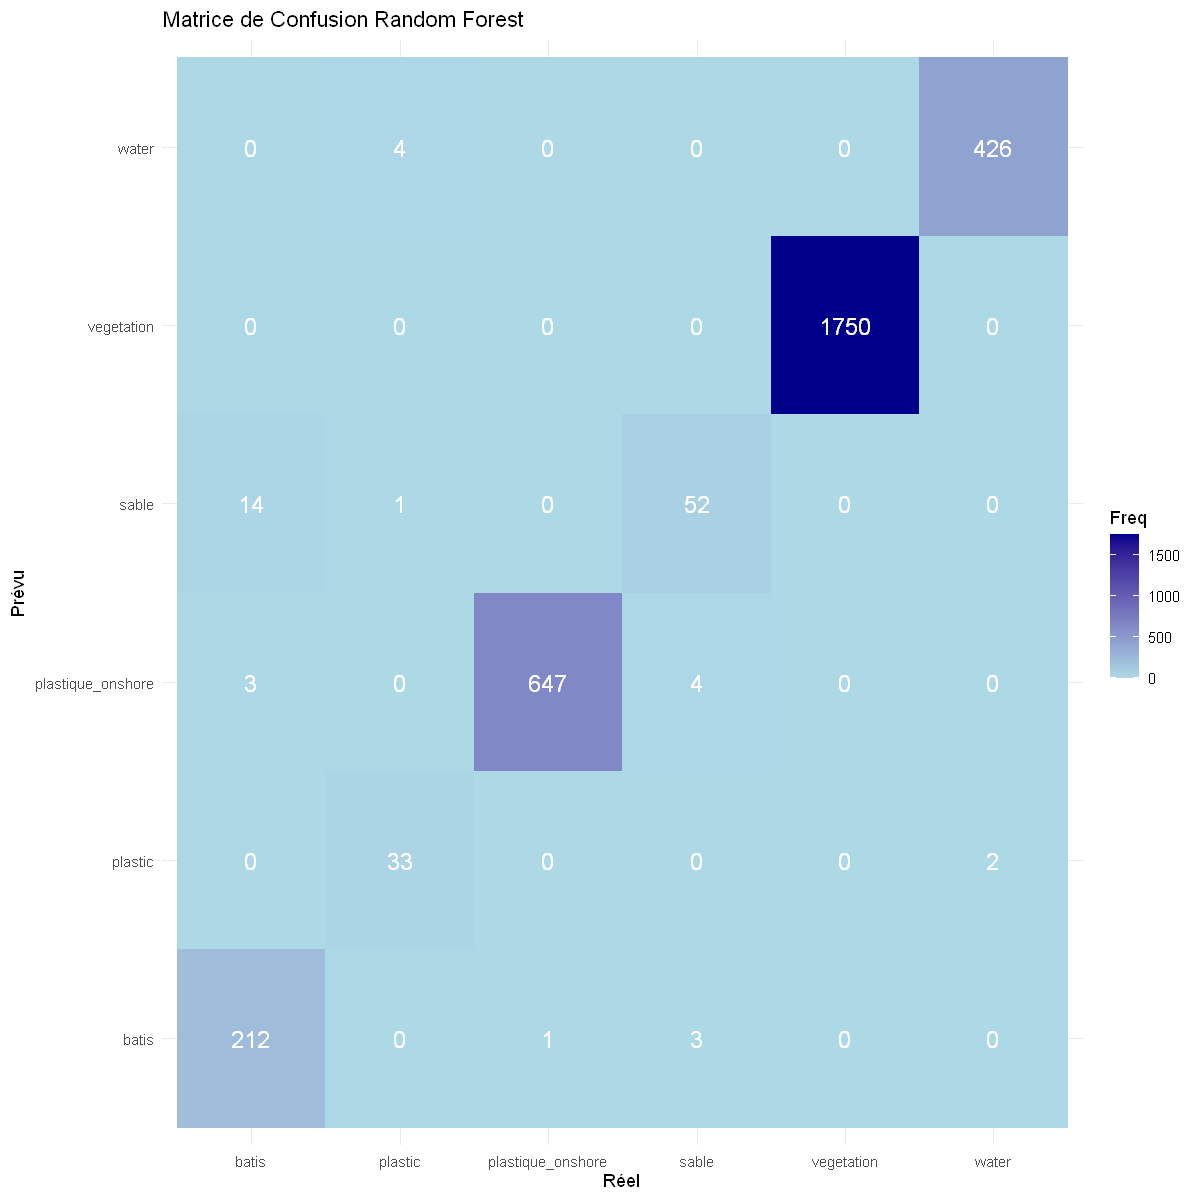

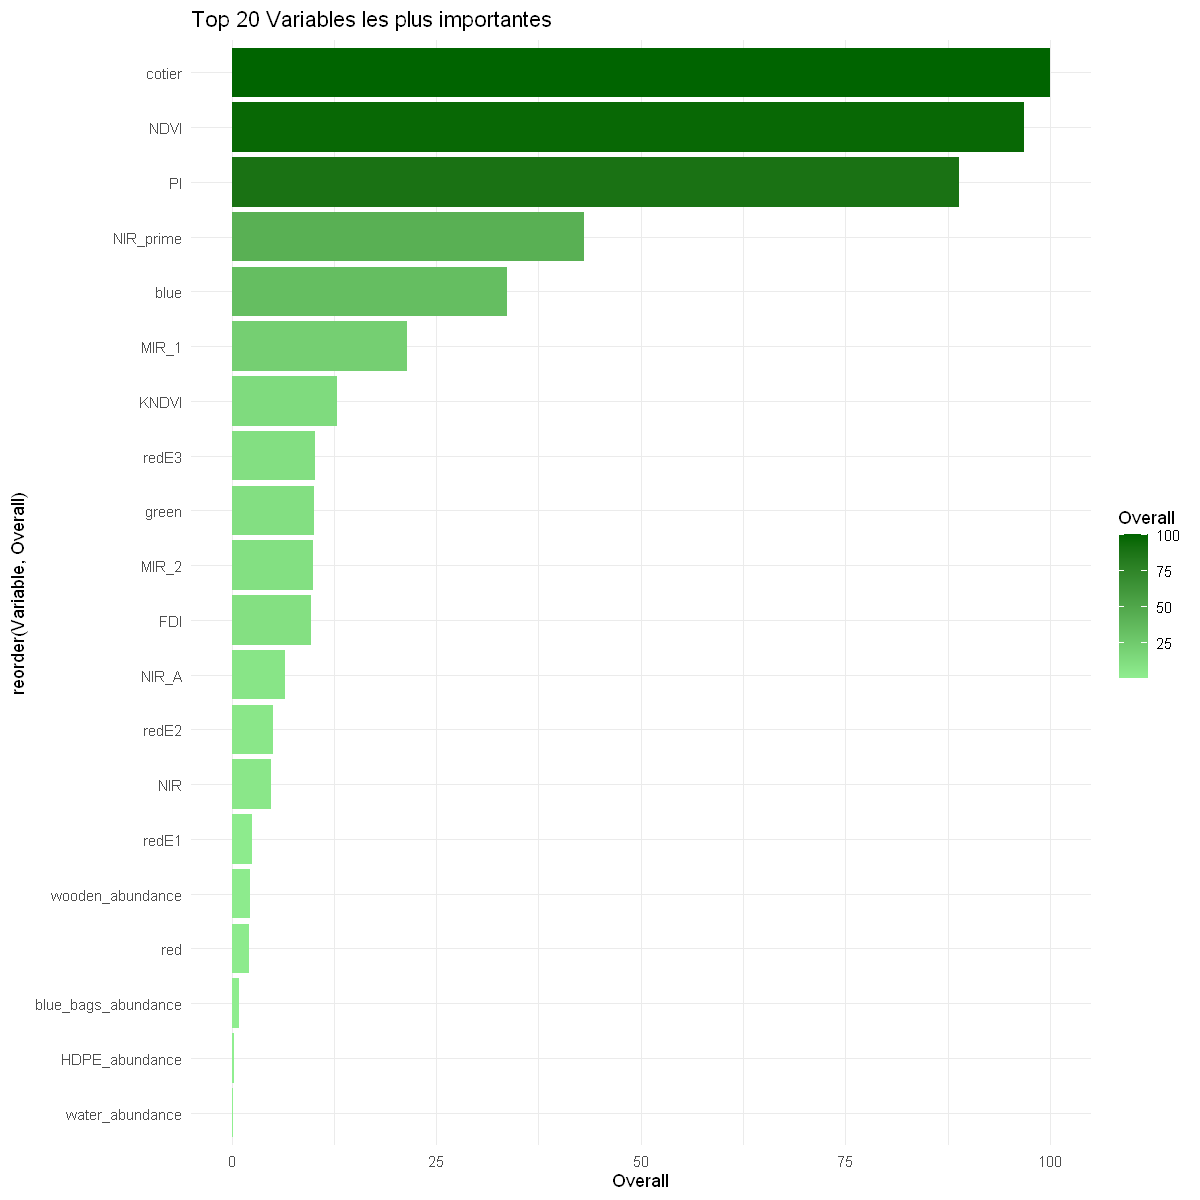

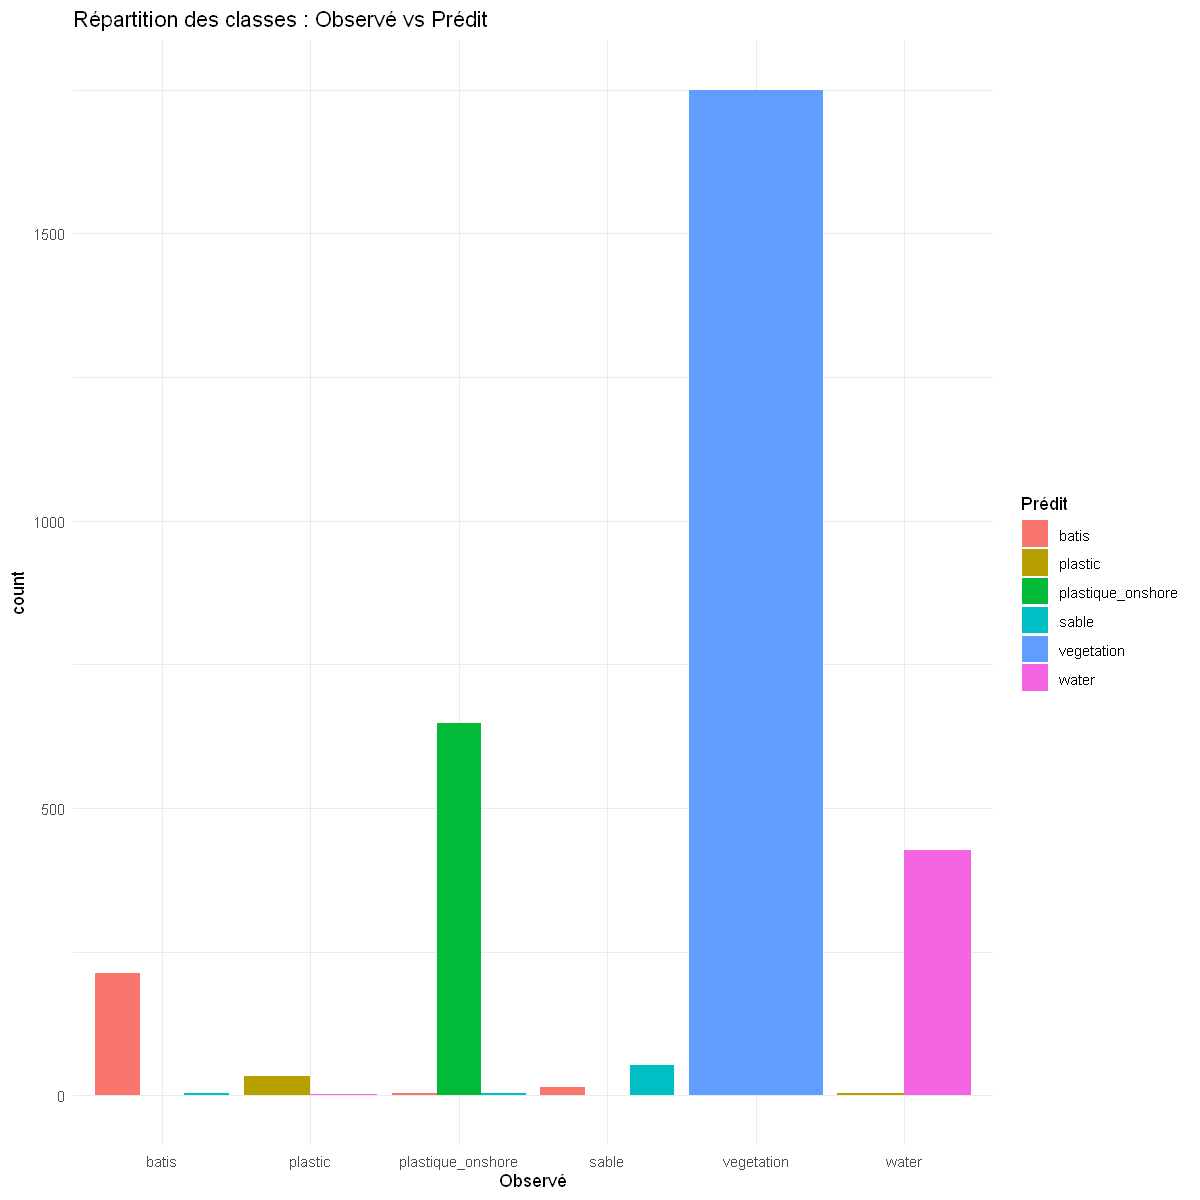

In [36]:
# Variable cible indiquer que c'est categorielle necessaire pour la classification
data$id <- as.factor(data$id)

# Diviser les données en ensembles d'entraînement et de test
set.seed(123)
trainIndex <- caret::createDataPartition(data$id, p = .8, list = FALSE, times = 1)
data_train <- data[trainIndex,]
data_test  <- data[-trainIndex,]

## entrainement du modèle
model_rf <- train(
  id ~ .,
  data = data_train,
  method = "rf",
  trControl = trainControl(method = "cv", number = 5),
  tuneLength = 5
)

# -----------------------------------------
# Prédictions sur le jeu de test
# -----------------------------------------
pred_rf <- predict(model_rf, newdata = data_test)

# -----------------------------------------
# Matrice de confusion et métriques
# -----------------------------------------
cm <- confusionMatrix(pred_rf, data_test$id)
print(cm)

# Heatmap de la matrice de confusion
cm_table <- as.data.frame(cm$table)
colnames(cm_table) <- c("Réel", "Prévu", "Freq")

ggplot(cm_table, aes(x = Réel, y = Prévu, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "white", size = 5) +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  theme_minimal() +
  ggtitle("Matrice de Confusion Random Forest")

# -----------------------------------------
# Importance des variables
# -----------------------------------------
importance <- varImp(model_rf)
importance_df <- as.data.frame(importance$importance)
importance_df$Variable <- rownames(importance_df)
importance_df <- importance_df[order(importance_df$Overall, decreasing = TRUE), ]

ggplot(importance_df[1:20, ], aes(x = reorder(Variable, Overall), y = Overall, fill = Overall)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  scale_fill_gradient(low = "lightgreen", high = "darkgreen") +
  theme_minimal() +
  ggtitle("Top 20 Variables les plus importantes")

# -----------------------------------------
# Prédictions vs Observations
# -----------------------------------------
df_pred <- data.frame(Observé = data_test$id, Prédit = pred_rf)

ggplot(df_pred, aes(x = Observé, fill = Prédit)) +
  geom_bar(position = "dodge") +
  theme_minimal() +
  ggtitle("Répartition des classes : Observé vs Prédit")


# Enregistrer le modèle entrainé

Nous allons enrégistré le modèle entrainé par utiliser le meme pour la classification des images sentinel-2 avec le même modèle

In [37]:
## voir les differentes calsse
print(levels(data$id))

# define path
setwd(dir_base)
setwd(chemin)

# Enregistrer le modèle
saveRDS(model_rf, file = "./model_entraine_RF.rds")

[1] "batis"             "plastic"           "plastique_onshore"
[4] "sable"             "vegetation"        "water"            


# Classification avec le modèle

Warning message:
"[vect] Z coordinates ignored"


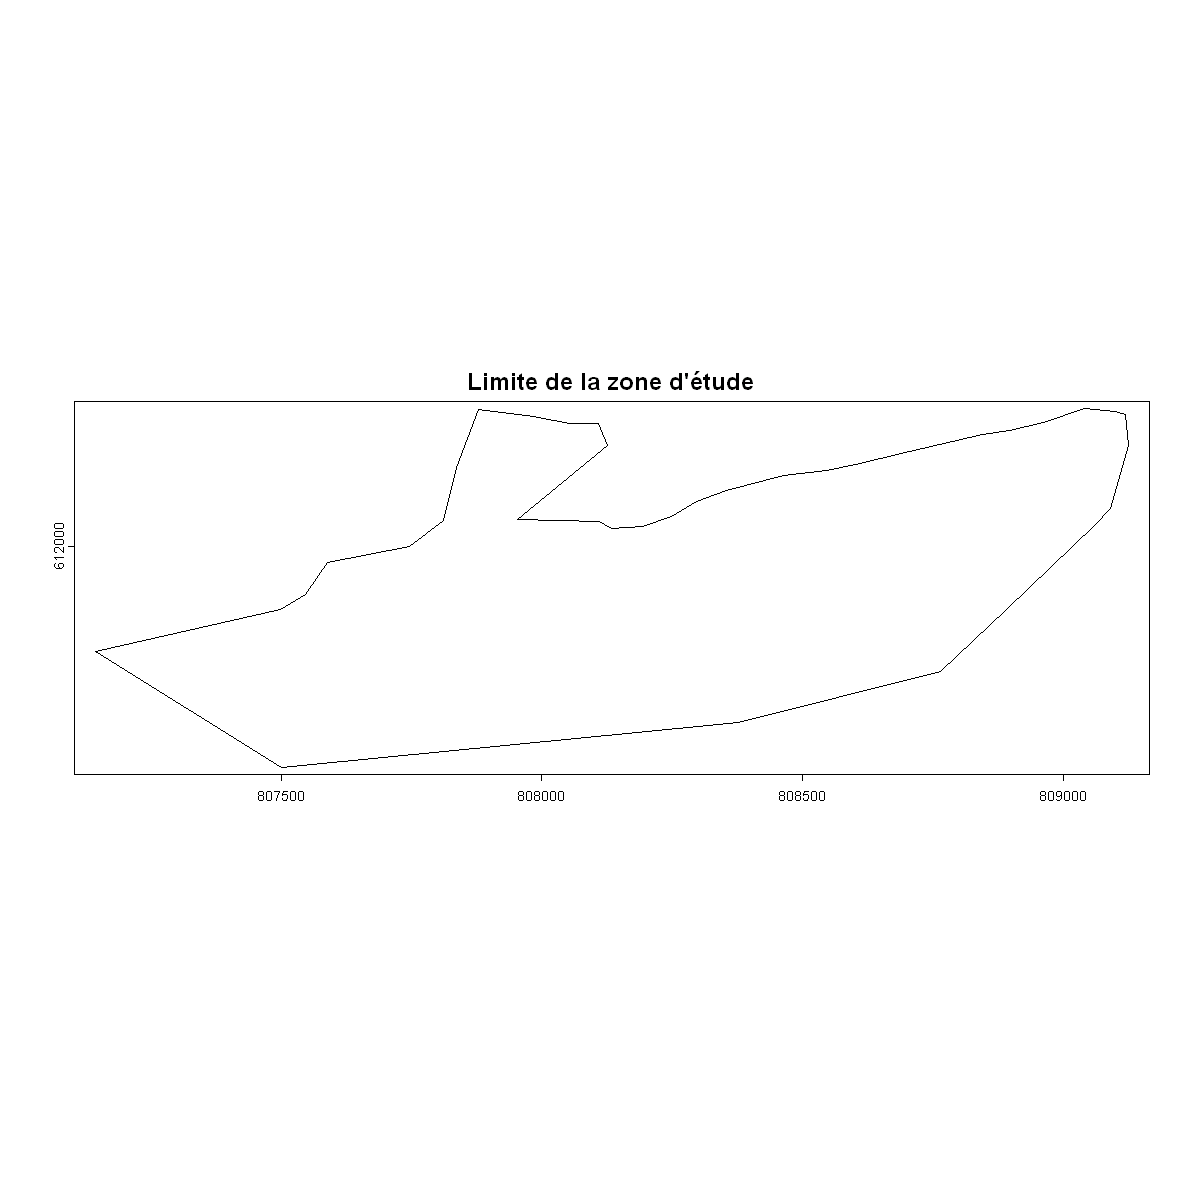

In [43]:
# path for raster multilyare use for clasification
chemin_entre <- "./DATA_Coastal_Plastic/STUDY_DATASET_PROCESSEDS/indices_unmixing_results"

# define path
setwd(dir_base)

# path for study zone use to mask raster classify
study_zone <- "./DATA_Coastal_Plastic/STUDY_DATASET_PROCESSEDS/indices_unmixing_results/jamestown_FO_MASK.shp"

## convert in to vect
study_zone <- terra::vect(study_zone)
plot(study_zone, main = "Limite de la zone d'étude")

# list of folder
setwd(chemin_entre)
liste_dossiers <- list.dirs(path='.', full.names=TRUE)


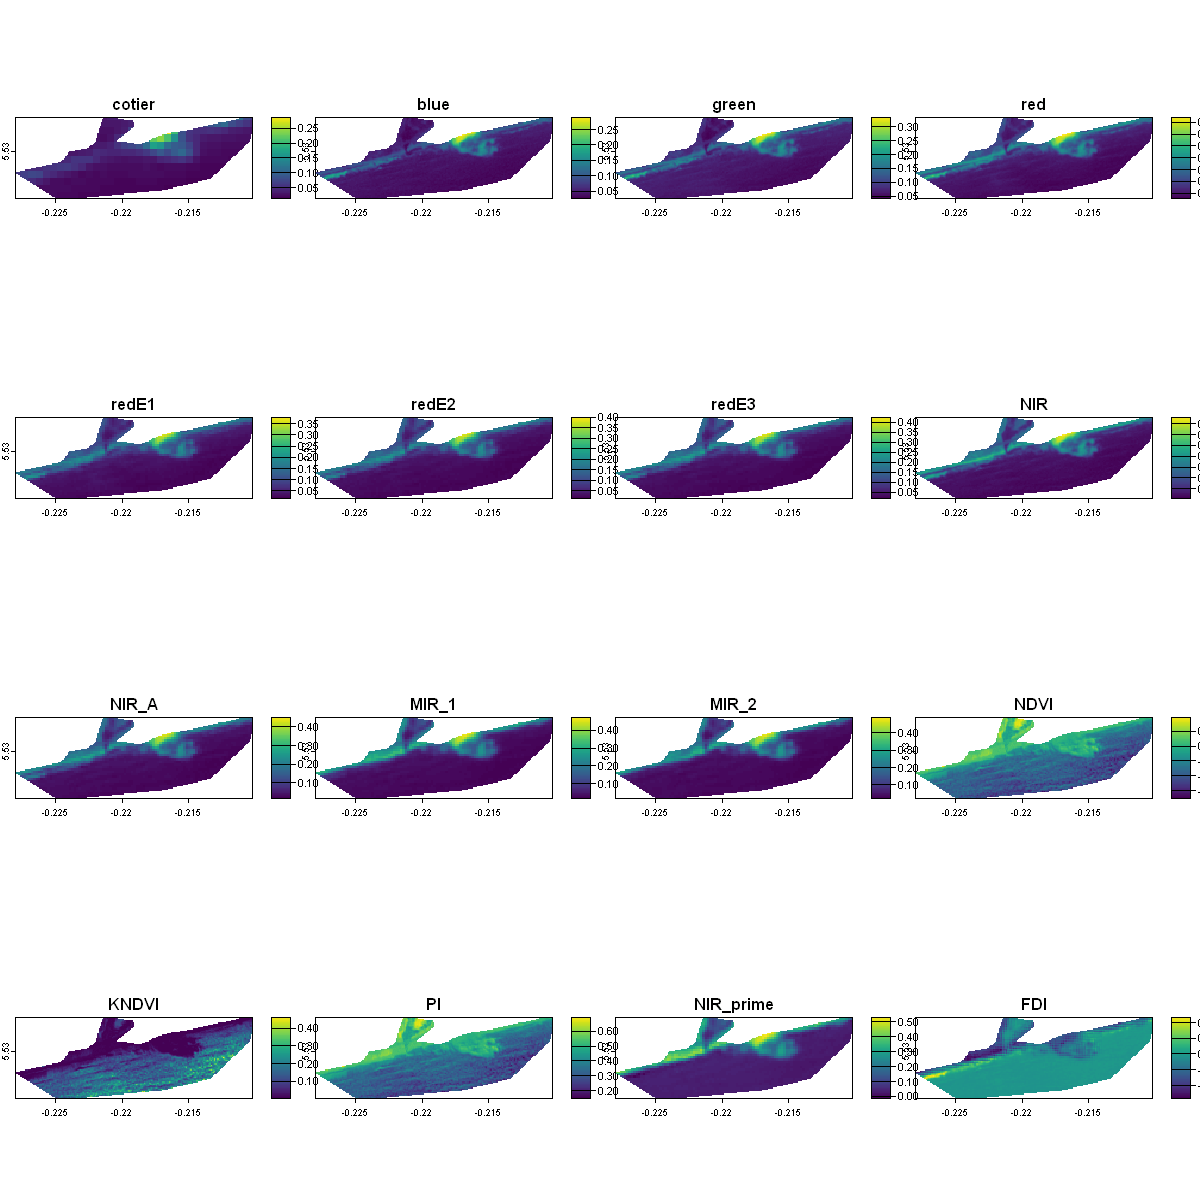

Les classes d'origine utilisées pendant l'entrainement du modèle :
[1] "batis"             "plastic"           "plastique_onshore"
[4] "sable"             "vegetation"        "water"            

Les classes présentes après classification avec le modèle RF :
[1] "batis"             "water"             "sable"            
[4] "vegetation"        "plastique_onshore" "plastic"          


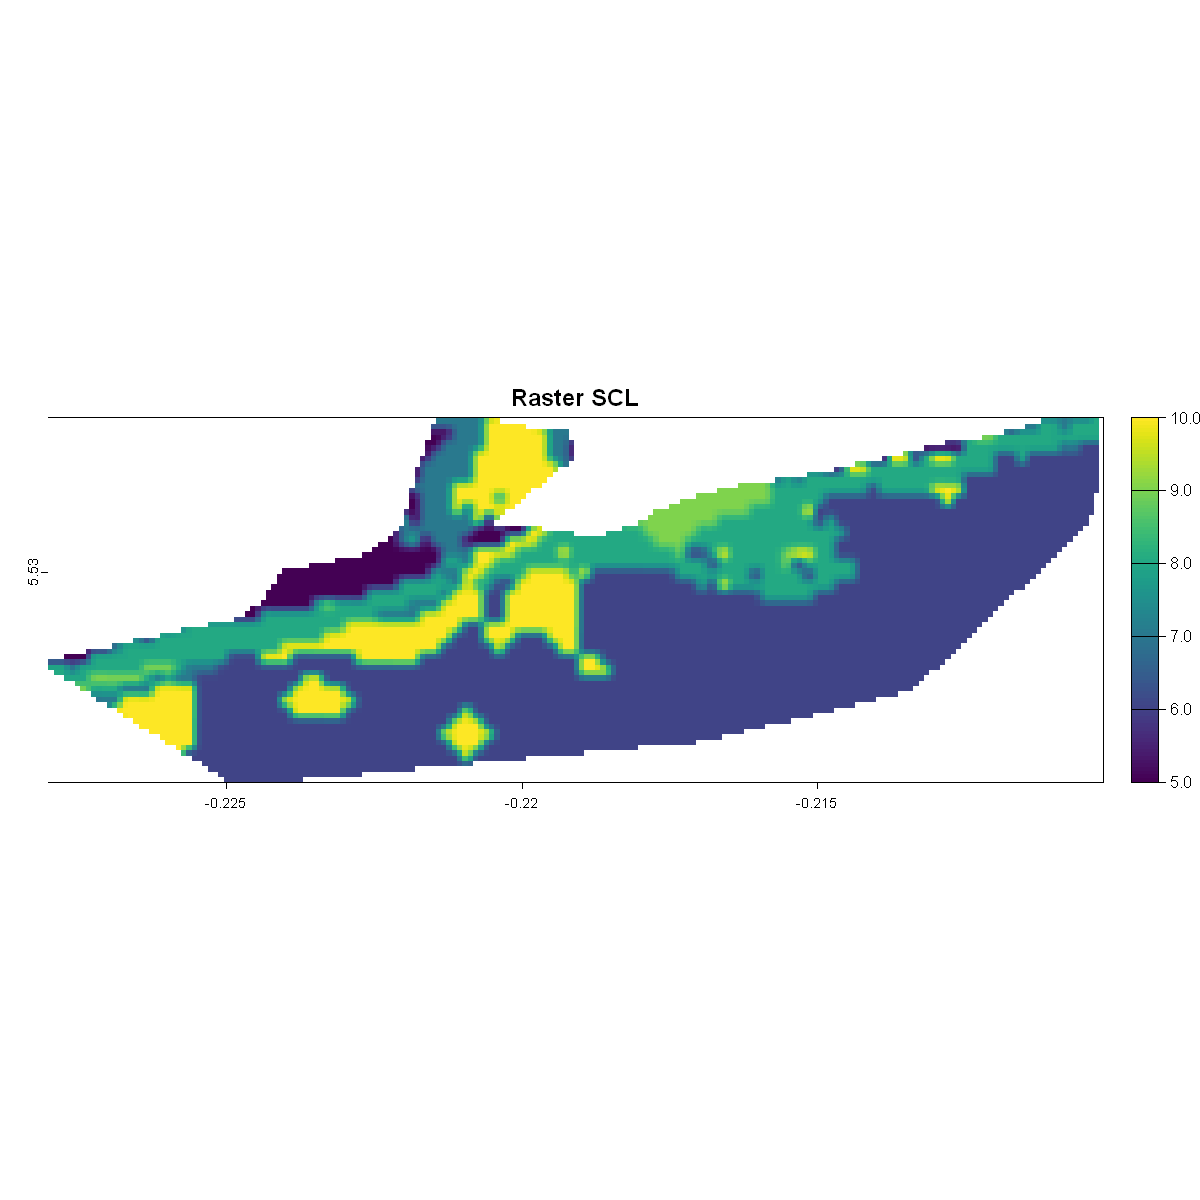

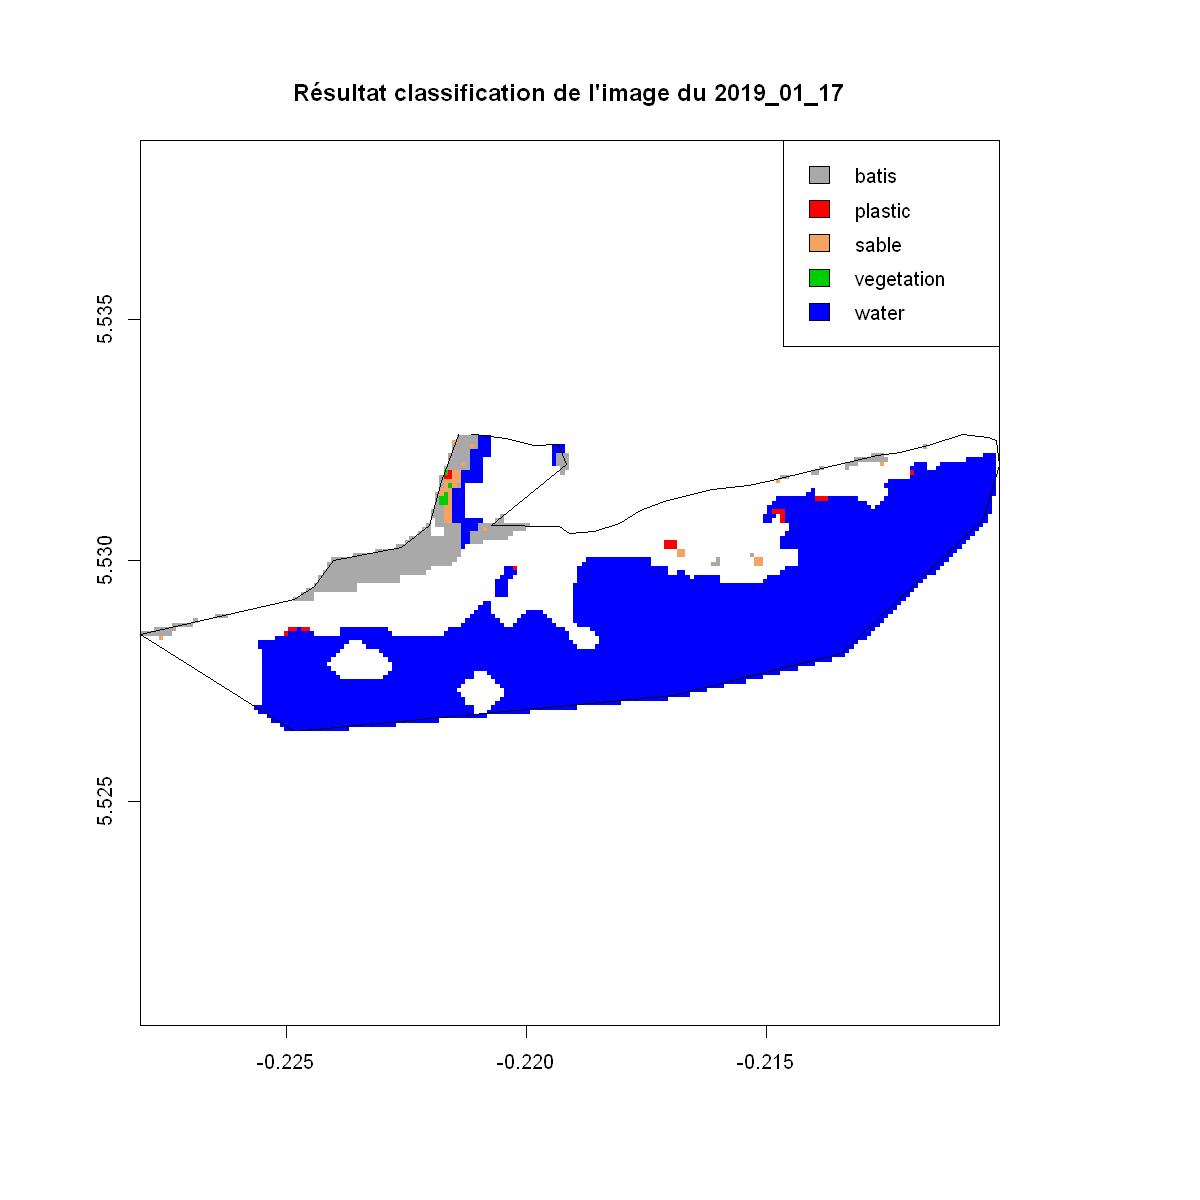

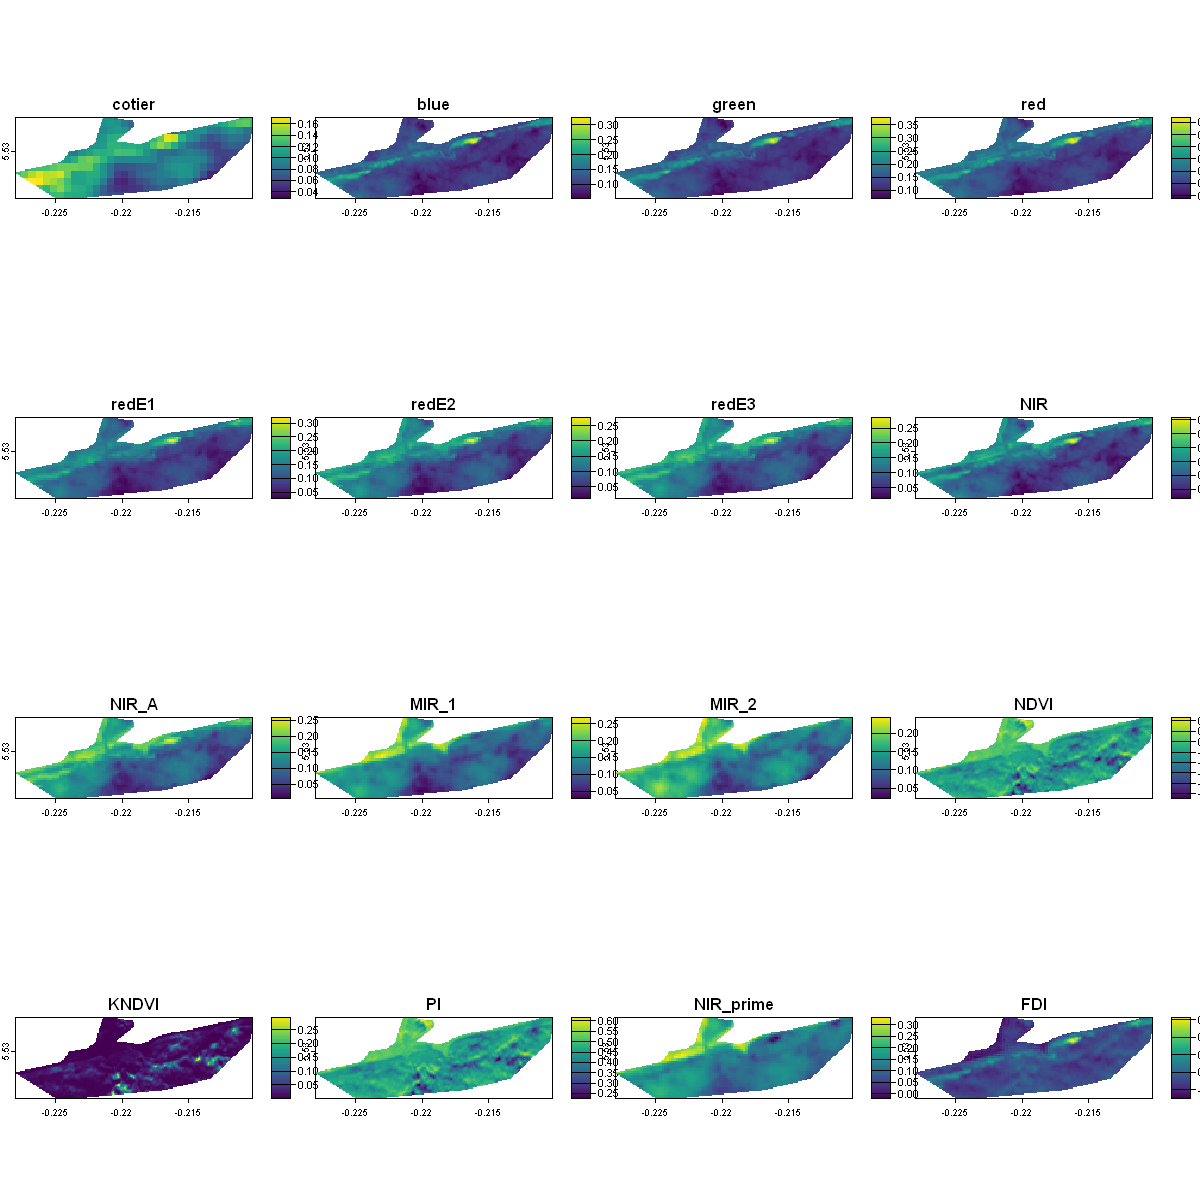

Les classes d'origine utilisées pendant l'entrainement du modèle :
[1] "batis"             "plastic"           "plastique_onshore"
[4] "sable"             "vegetation"        "water"            

Les classes présentes après classification avec le modèle RF :
[1] "batis" "sable" "water"


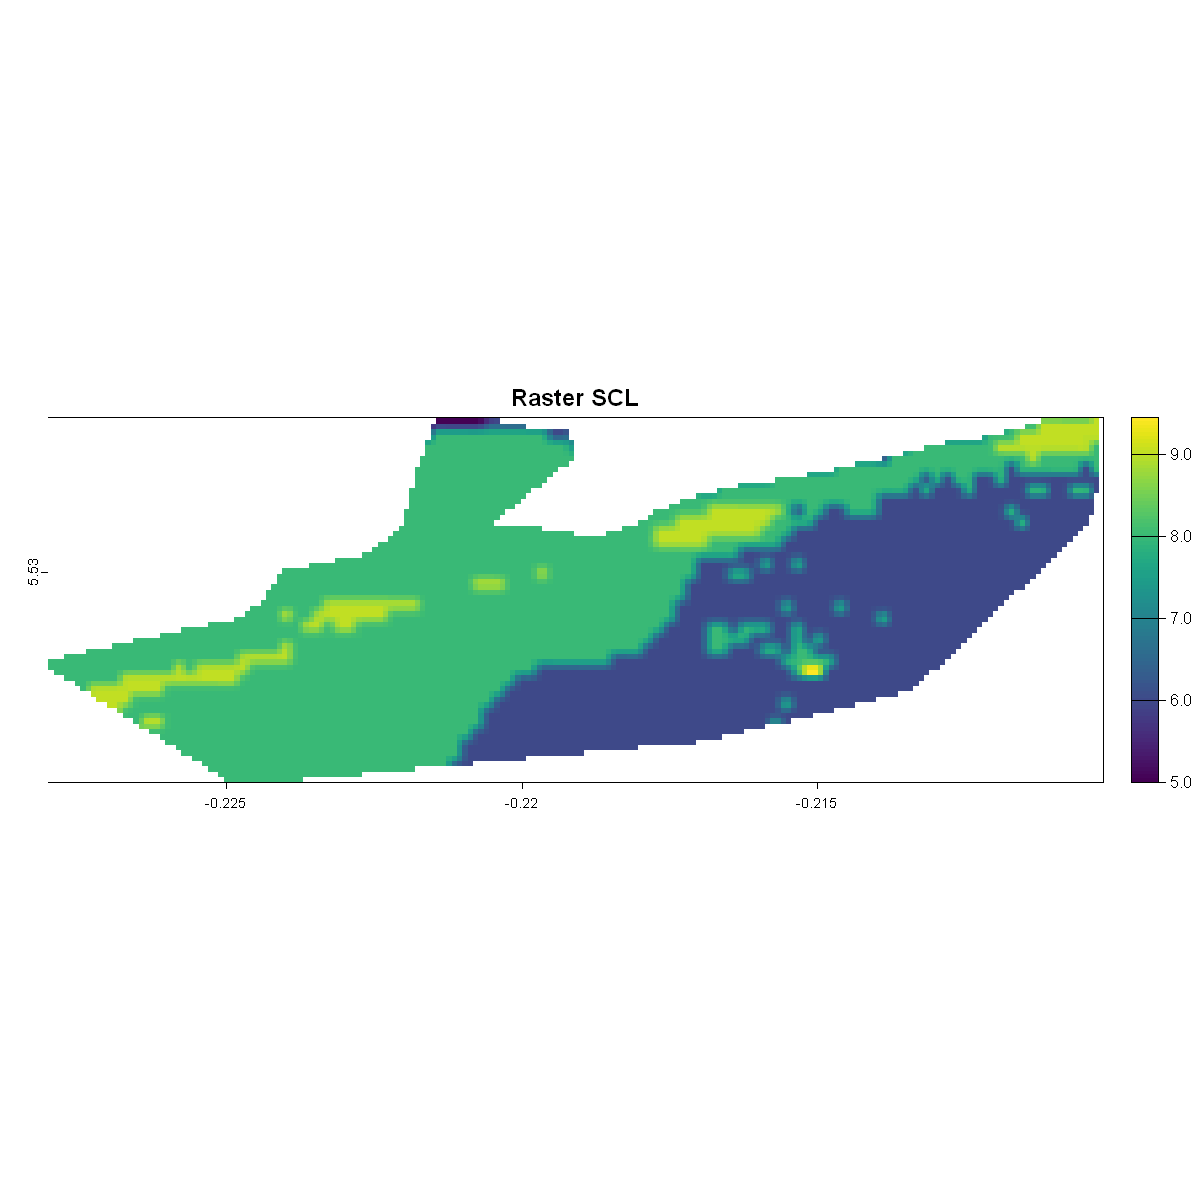

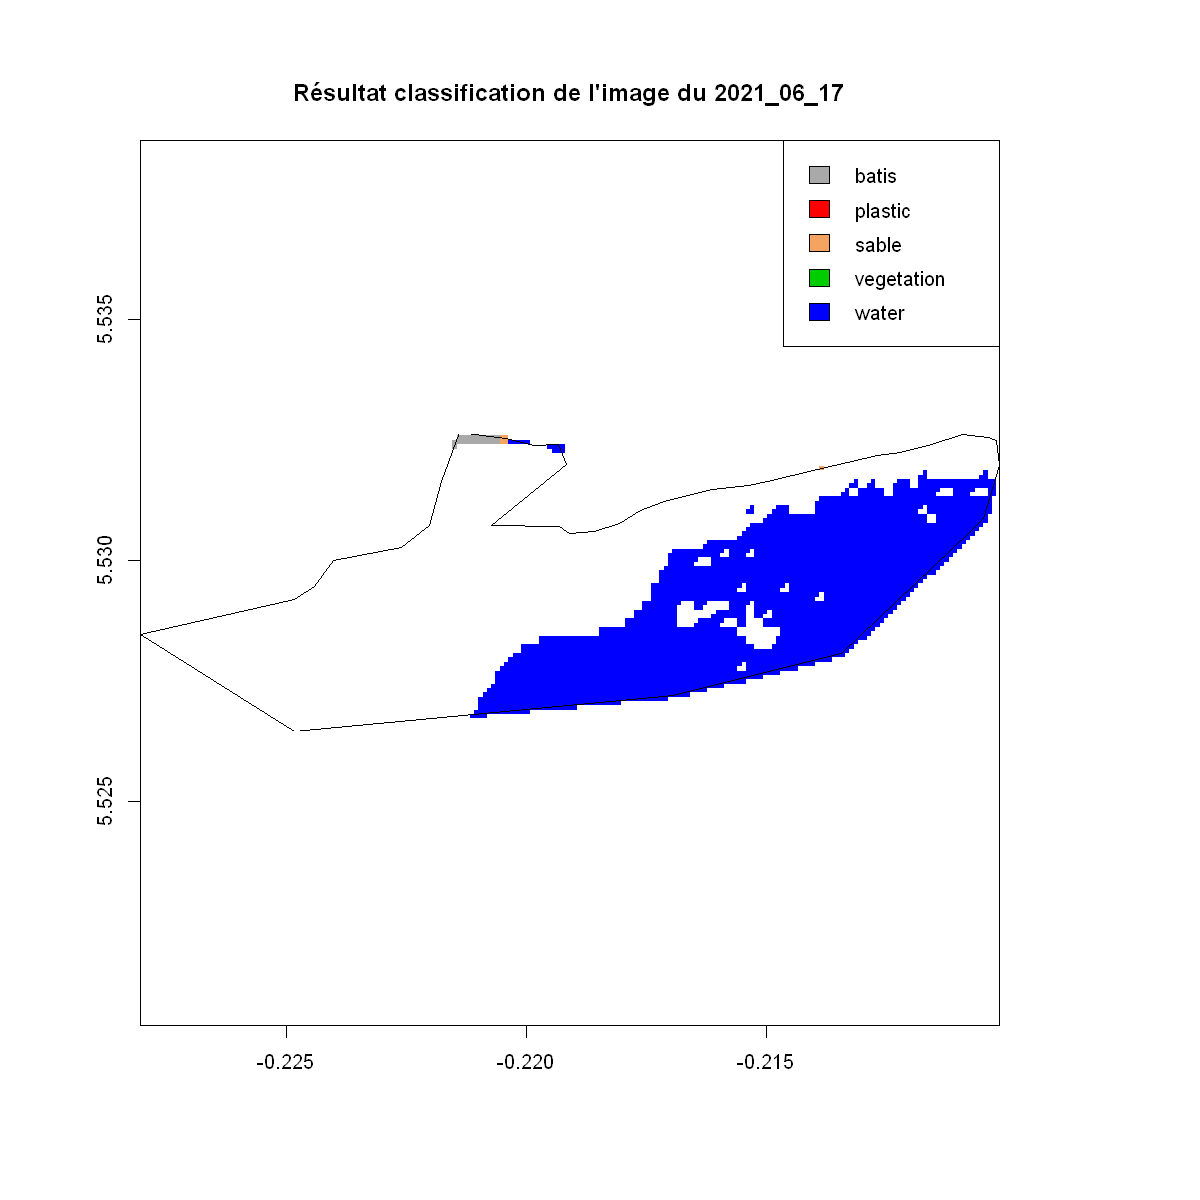

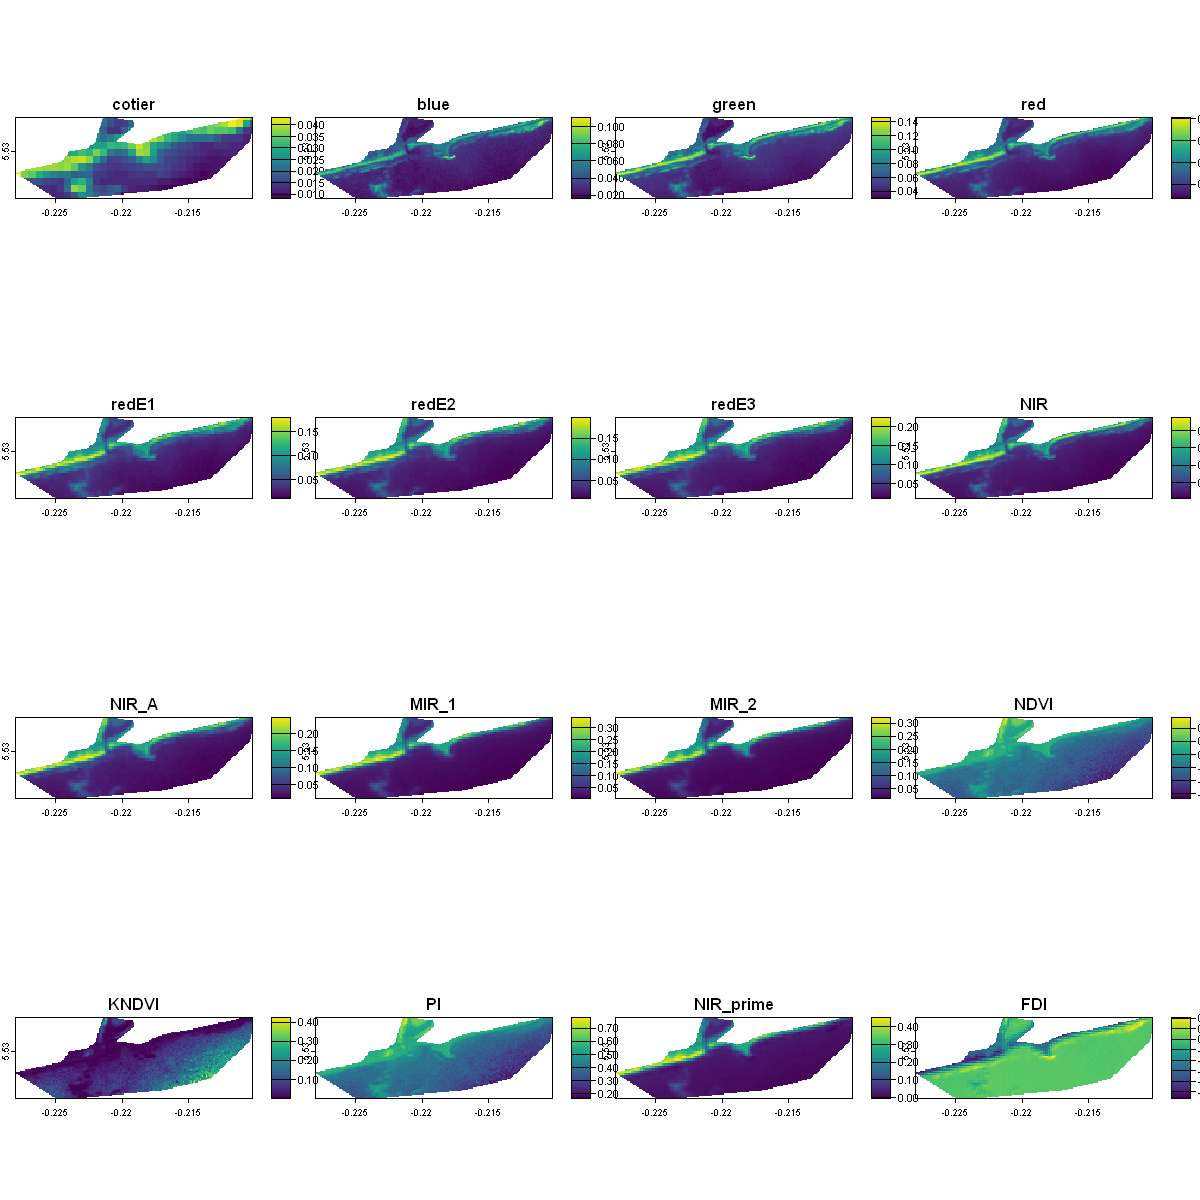

Les classes d'origine utilisées pendant l'entrainement du modèle :
[1] "batis"             "plastic"           "plastique_onshore"
[4] "sable"             "vegetation"        "water"            

Les classes présentes après classification avec le modèle RF :
[1] "vegetation" "water"      "sable"      "plastic"    "batis"     


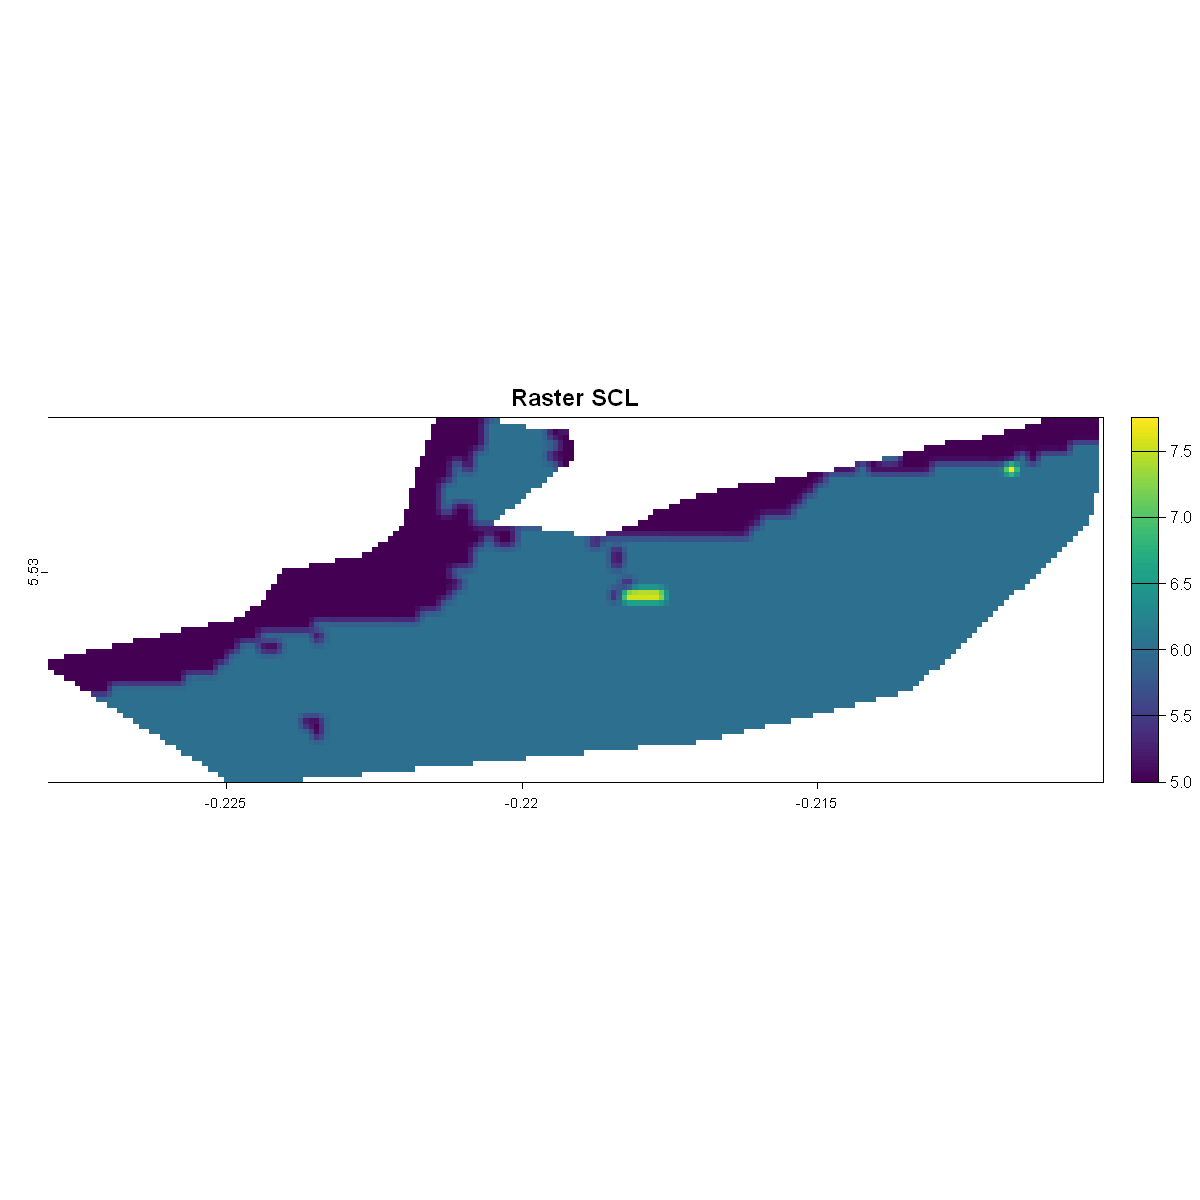

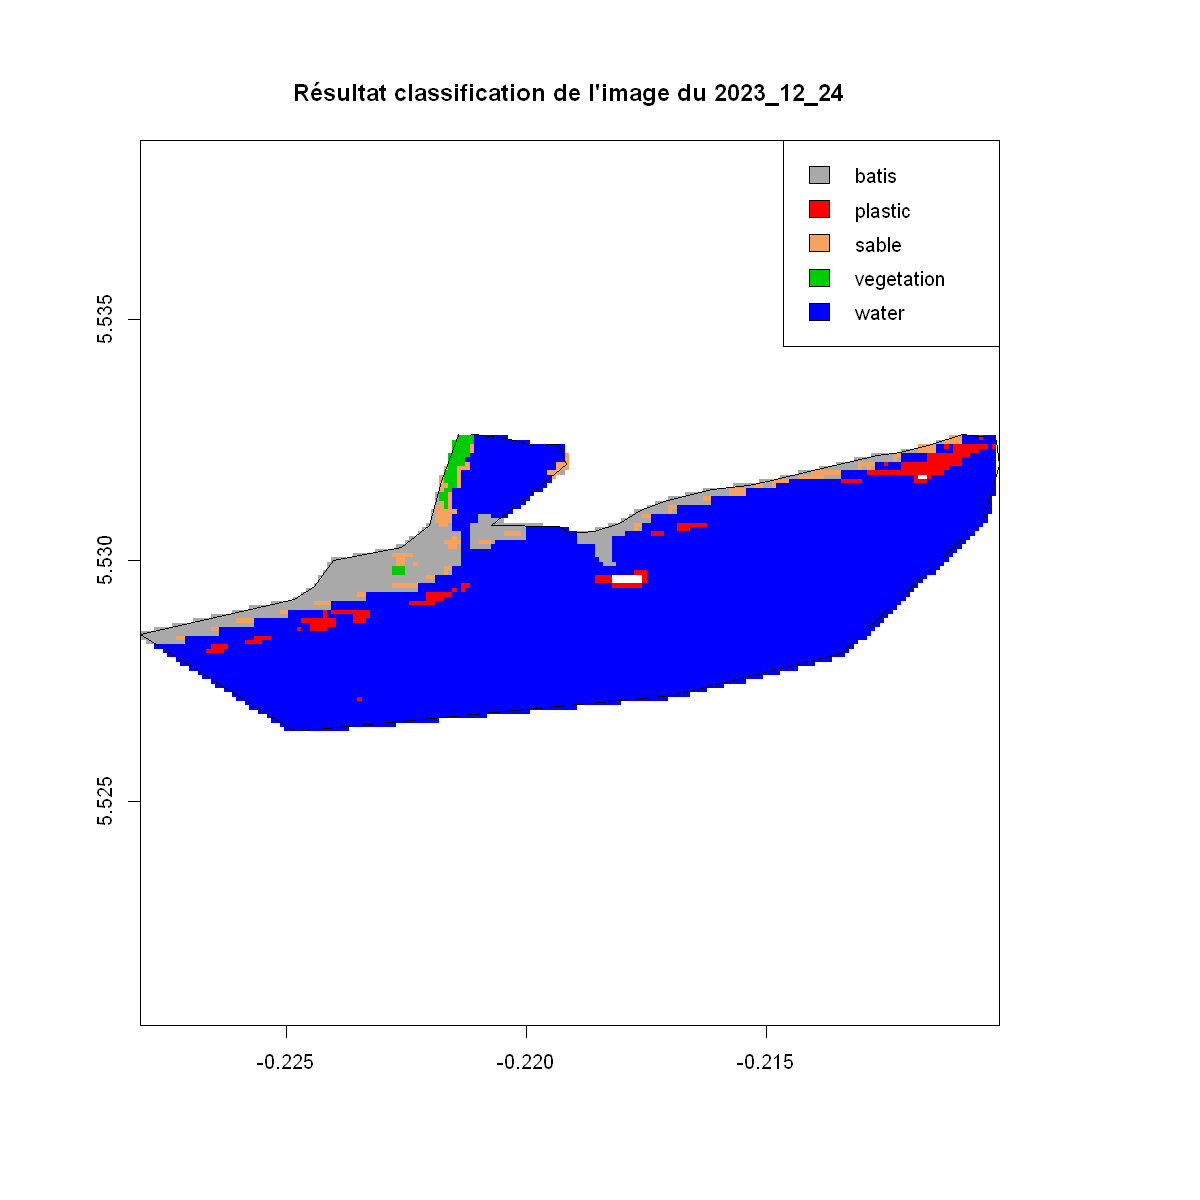

In [44]:
for (i in 2: length(liste_dossiers)) {
    
  # define path
  setwd(dir_base)
  setwd(chemin_entre)
  setwd(liste_dossiers[i])
  
  all_band <- list.files(pattern = '*.tif$')
  # Filtre pour sélectionner les noms de fichiers ne contenant ni "unmixed" ni "SCL"
  rhos_band_all<-grep(all_band, pattern="unmixed|SCL", invert=TRUE, value=TRUE)
  rhos_band_unmixed_all<-grep(all_band, pattern='unmixed', invert=FALSE, value=TRUE)
  rhos_band_SCL_all<-grep(all_band, pattern='SCL', invert=FALSE, value=TRUE)
  
  if(length(rhos_band_unmixed_all)>0){
    for (n in 1: length(rhos_band_all) ) {

      # define path
      setwd(dir_base)
      setwd(chemin_entre)
      setwd(liste_dossiers[i])
      
      ## convertion en raster spatRaster###########################################################
      nom_raster_classifier <- rhos_band_all[n]
      rhos_band <- terra::rast(rhos_band_all[n])
      rhos_band_unmixed <- terra::rast(rhos_band_unmixed_all[n])
      rhos_band_SCL <- terra::rast(rhos_band_SCL_all[n])
      
      ########renomme les bandes ###############################################################
      band_name<- c("cotier", "blue", "green", "red", "redE1", "redE2", "redE3", "NIR", "NIR_A", "MIR_1", "MIR_2", "NDVI", "KNDVI", "PI", "NIR_prime", "FDI")
      band_name_unmixe <- c("plastics_bottles_abundance", "fish_net_abundance", "blue_bags_abundance", "water_abundance", "HDPE_abundance", "wooden_abundance", "long", "lat")
      
      names(rhos_band)<- band_name
      names(rhos_band_unmixed)<- band_name_unmixe
      
      # ### mettre les deux raster a la  même extension #################################
      terra::ext(rhos_band_unmixed)<- terra::ext(rhos_band)
      rhos_band_SCL<- terra::project(rhos_band_SCL,rhos_band)
      rhos_band_SCL <- terra::resample(rhos_band_SCL, rhos_band)      
      
      # Fusionner les deux rasters en un seul en spécifiant les bandes à conserver
      rhos_band_unmixed<-rhos_band_unmixed[[1:6]]
      fussion <- list(rhos_band, rhos_band_unmixed)
      fussion <- terra::rast(fussion)
      
      # dÃ©coupage du raster selon l'emprise du vecteur
      study_zone <- terra::project(study_zone,fussion)
      rhos_band_SCL<- terra::project(rhos_band_SCL, fussion)
      fussion <- terra::crop(fussion, study_zone)
      rhos_band_SCL <- terra::crop(rhos_band_SCL, study_zone)
      
      #Mask des zones hors zones d'étude 
      fussion <- terra::mask(fussion, study_zone)
      rhos_band_SCL <- terra::mask(rhos_band_SCL, study_zone)
      terra::plot(fussion)
      terra::plot(rhos_band_SCL, main="Raster SCL")
      
      ##############affichage des bandes #############################################
      #plot(fussion[[1:7]])
      #plot(fussion[[8:14]])
      #plot(fussion[[15:21]])
      
      # si l'utilisateur souhaite masquer les résultats, on charge le raster SCL une fois pour toutes
      mask_raster <- TRUE
      thin_cirrus<- TRUE
      casted_shadows<- TRUE
      
      # une fonction pour masquer un raster selon les nuages et autres se trouvant dans le raster SCL
      apply_mask <- function(raster, scl){
        
        # on applique le masque à la bande
        raster <- terra::mask(raster, scl)
        return(raster)
      }
      
      
      # si l'utilisateur souhaite masquer les résultats, on charge le raster SCL une fois pour toutes
      if(mask_raster == TRUE){
        # on créé la matrice de reclassification des ombres, nuages et autres en no data
        # soit les classes de 0 à 3 et de 8 à 10
        m <- c(0, 3,NA,
               7, 10,NA)
        rclmat <- matrix(m, ncol=3, byrow=TRUE)
        
        # on applique le masque au raster SCL 
        scl <- terra::classify(rhos_band_SCL, rclmat, include.lowest=TRUE)
        rhos_band_SCL<- scl
      }
      
      # si l'utilisateur souhaite masquer les nuages
      if(mask_raster == TRUE){
        fussion <- apply_mask(fussion, rhos_band_SCL)
      }
      
      ##creation tableau data test ###################################"
      table_data<- c("cotier", "blue", "green", "red", "redE1", "redE2", "redE3", "NIR", "NIR_A", "MIR_1", "MIR_2", "FDI", "KNDVI", "NDVI", "NIR_prime", "PI",
                     "plastics_bottles_abundance", "fish_net_abundance", "blue_bags_abundance", "water_abundance", "HDPE_abundance", "wooden_abundance")
      
      data_zone_etude <- data.frame(matrix(nrow = 0, ncol = length(table_data)))
      colnames(data_zone_etude)<- table_data
      
      ### # Convertition du RasterStack en data.frame
      raster_df <- terra::as.data.frame(fussion, na.rm = FALSE)
      
      # verifier si raster_df contient les meme nom de colonne que  table_data
      raster_df <- raster_df[, colnames(raster_df) %in% table_data]
      # Réorganiser les colonnes de raster_df dans le même ordre que table_data
      raster_df <- raster_df[, table_data]
      
      # Vérifier le nombre de lignes de raster_df
      nb_lignes_raster_df <- nrow(raster_df)
      
      # Ajuster le nombre de lignes de data_zone_etude pour correspondre à raster_df
      data_zone_etude <- data_zone_etude[1:nb_lignes_raster_df, ]
      
      # Ajouter les données à data_zone_etude
      data_zone_etude <- raster_df
      
      has_non_na <- any(!is.na(data_zone_etude))
      
      ##############################################################################
      #############################################################################
      ###########################################################################
      
      if(has_non_na == TRUE){
          
        # define path
        setwd(dir_base)       
        model <- readRDS(file = "./DATA_Coastal_Plastic/model_entraine_RF.rds")
        
              
        ### classifier un raster######################################
        classifier <- predict(model, newdata = data_zone_etude)
        # convertir num pour la construction de la classification
        classifier_vals <- as.numeric(classifier) 
        classifier_df<- as.data.frame(classifier_vals)

        # Tous les niveaux du facteur (classes d'origine du modèle)
        levels_class <- levels(classifier)        
        # Classes réellement présentes dans la classification actuelle
        levels_classif_output <- unique(as.character(classifier))
        
        cat("Les classes d'origine utilisées pendant l'entrainement du modèle :\n")
        print(levels_class)
        
        cat("\nLes classes présentes après classification avec le modèle RF :\n")
        print(levels_classif_output)
                
        # Convertir les prédictions en un objet raster
        # Créer un raster avec les mêmes dimensions que votre raster d'entrée
        # extraire le raster de reference
        rast_ref <- fussion[[1]]
        rast_ref_df<-terra::as.data.frame(rast_ref, na.rm = FALSE)
        #utiliser le raster de refernece pour creer un raster vide
        raster_classifier <- terra::rast(terra::ext(rast_ref), resolution=terra::res(rast_ref), crs = terra::crs(rast_ref))
        # Initialiser un compteur pour les lignes de df2
        count <- 1
        # Remplacer les lignes sans NA dans df1 par les lignes correspondantes de df2
        for (i in 1:nrow(rast_ref_df)) {
          if (!any(is.na(rast_ref_df[i, ]))) {
            # Vérifier si le compteur a dépassé le nombre de lignes de df2
            if (count <= nrow(classifier_df)) {
              rast_ref_df[i, ] <- classifier_df[count, ]
              count <- count + 1
            } else {
              # Si toutes les lignes de df2 ont été utilisées, arrêter la boucle
              break
            }
          }
        }
        
        # Convertir les prédictions en un objet raster
        # Assigner les prédictions aux cellules du raster
        raster_classifier<- setValues(raster_classifier, as.matrix(rast_ref_df))
        
        ## fussionner les classse plastic and plastic onshore            
        raster_classifier[raster_classifier== 2| raster_classifier==3] <- 2 
        raster_classifier[scl==6] <- 6

        # Enlever plastic_onshore dans vecteur puis que fussionner
        # Mettre à jour levels_class
        levels_class_Update <- levels_class[levels_class != "plastique_onshore"]
                
        ##export du raster classifier
        chemin_sortie <- "./DATA_Coastal_Plastic/RESULTS_CLASSIFY"
        setwd(chemin_sortie)
        ##extraire le nom et la date de l'image traitee'
        export_rast_all <- substring(nom_raster_classifier, 1, 18)
        export_rast <- paste(export_rast_all, '.tif', sep='')
        export_rast_scl <- paste(export_rast_all, '_SCL_MASK', '.tif', sep='')
        
        writeRaster(raster_classifier, export_rast, overwrite= TRUE)
        writeRaster(scl, export_rast_scl, overwrite= TRUE)
        
        # Visualiser le raster de prédictions
        #plot(raster_classifier, main = paste ("Résultat classification de l'image du", substring(export_rast_all, 9, 38), sep= ' '))
        # # convertir de terra à raster pour affichage avec les catégorielle
        cols <- c("darkgrey",  # batis
          "red",       # plastic
          "sandybrown",# sable
          "green3",    # vegetation
          "blue"       # water
        )     
          
        r <- raster(raster_classifier)  
        #r <- as.factor(r)
        plot(r, legend = FALSE, col = cols, main = paste ("Résultat classification de l'image du", substring(export_rast_all, 9, 38), sep= ' ') )
        legend("topright", legend = levels_class_Update, fill = cols)
        plot(study_zone, add=TRUE, col = NA, border = 'black')
        
      }else{        
        print("l'image de cette date ne contient que des nuages")
      }
      
    }
    
    
  }else{

      print("les données de demelage spectrale manquent (spectral unmixing bands missing)") 
    
  }
    
  # define path
  setwd(dir_base)
  setwd(chemin_entre)
}
